# Assignment 5 - RNN
## Task: 4
Author: Soham Vaishnav
Roll No.: 2022112002

## Importing modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wandb

import os
import sys 
import shutil
import time

import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go

AssignDIR = os.path.dirname(os.path.dirname(os.path.abspath('RNN.ipynb')))
CurrDIR = os.path.dirname(os.path.abspath('RNN.ipynb'))
UserDIR = os.path.dirname(AssignDIR)

sys.path.append(UserDIR)

from sklearn.preprocessing import StandardScaler
import librosa

RawDataDIR = os.path.join(UserDIR, "./data/external/")
PreProcessDIR = os.path.join(UserDIR, "./data/interim/5/")

## Loading/Creating Dataset

In [38]:
def getData(data_length, max_seq_length=16):
    data= []
    seq_lengths = []
    np.random.seed(0)
    for i in range(data_length):
        seq_length = np.random.choice(list(range(1, max_seq_length + 1)))
        seq_lengths.append(seq_length)
        seq = np.random.choice([0, 1], size=(seq_length, 1)).tolist()
        if (len(seq) < max_seq_length):
            for i in range(max_seq_length - len(seq)):
                seq.append([0])
        data.append([seq, np.sum(seq)])
    return data, seq_lengths

data_seq, seq_lengths = getData(100000)

In [39]:
for i in range(10):
    print(data_seq[i])

[[[1], [1], [0], [1], [1], [1], [1], [1], [1], [1], [0], [0], [1], [0], [0], [0]], 10]
[[[0], [0], [0], [0], [1], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0]], 2]
[[[0], [0], [1], [1], [1], [1], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0]], 5]
[[[1], [0], [1], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]], 3]
[[[1], [0], [0], [1], [0], [1], [1], [1], [1], [1], [0], [1], [0], [1], [1], [1]], 11]
[[[0], [1], [0], [0], [1], [1], [0], [1], [0], [1], [0], [0], [0], [0], [0], [1]], 6]
[[[0], [0], [0], [1], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]], 2]
[[[0], [0], [1], [0], [1], [1], [1], [1], [1], [1], [0], [0], [0], [0], [0], [0]], 7]
[[[1], [1], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]], 3]
[[[1], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]], 2]


## RNN Model

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

In [63]:
train_data = data_seq[:int(len(data_seq)*0.8)]
train_seq_lengths = seq_lengths[:int(len(data_seq)*0.8)]
val_data = data_seq[int(len(data_seq)*0.8):int(len(data_seq)*0.9)]
val_seq_lengths = seq_lengths[int(len(data_seq)*0.8):int(len(data_seq)*0.9)]
test_data = data_seq[int(len(data_seq)*0.9):]
test_seq_lengths = seq_lengths[int(len(data_seq)*0.9):]

class BitsData(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx][0], dtype=torch.float32), torch.tensor(self.data[idx][1], dtype=torch.float32)
    
train_loader = DataLoader(BitsData(train_data), batch_size=64, shuffle=True)
val_loader = DataLoader(BitsData(val_data), batch_size=64, shuffle=True)
test_loader = DataLoader(BitsData(test_data), batch_size=64, shuffle=True)

In [72]:
config = {
    'lr': 0.001,
    'epochs': 10,
    'hidden_size': 64,
    'n_layers': 2,
    'dropout': 0.2,
    'batch_norm': False,
    'input_size': 1,
    'nonlinearity': 'tanh'
}

In [73]:
from models.rnn.rnn import BitCounterRNN

model = BitCounterRNN(config)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=config['lr'])
model.fit(train_loader=train_loader, val_loader=val_loader, 
          criterion=criterion, optimizer=optimizer, lr=config['lr'], n_epochs=config['epochs'])

Epoch 1/10, MAE Train Loss: 2.1718273162841797, Val Loss: 2.264871597290039
Epoch 2/10, MAE Train Loss: 0.10454991459846497, Val Loss: 0.1064460277557373
Epoch 3/10, MAE Train Loss: 0.20521315932273865, Val Loss: 0.16167736053466797
Epoch 4/10, MAE Train Loss: 0.10896608233451843, Val Loss: 0.08722268044948578
Epoch 5/10, MAE Train Loss: 0.07096417248249054, Val Loss: 0.08848828822374344
Epoch 6/10, MAE Train Loss: 0.07445666939020157, Val Loss: 0.09601453691720963
Epoch 7/10, MAE Train Loss: 0.05365116521716118, Val Loss: 0.052614133805036545
Epoch 8/10, MAE Train Loss: 0.03241845965385437, Val Loss: 0.035465121269226074
Epoch 9/10, MAE Train Loss: 0.024574534967541695, Val Loss: 0.03446609154343605
Epoch 10/10, MAE Train Loss: 0.05387723073363304, Val Loss: 0.08943294733762741
Model trained successfully


In [26]:
model.save_model(os.path.join(CurrDIR, 'RNN_best_model_1.pth')) 

Model saved successfully at  c:\Users\Admin\smai-m24-assignments-SohamVaishnav\assignments\5\RNN_best_model_1.pth


## Comparing against random baseline

In [75]:
from sklearn.metrics import mean_absolute_error

def random_baseline(seq_length):
    np.random.seed(0)
    return [np.random.randint(0, length) for length in seq_length]

def compare_baseline(test_loader, baseline, seq_lengths):
    y_true = []
    y_pred = []
    for x, y in test_loader:
        y_true.extend(y.numpy())
    y_pred = baseline(seq_lengths)
    return mean_absolute_error(y_true, y_pred)

compare_baseline(test_loader, random_baseline, test_seq_lengths)

3.5896

Clearly, MAE for random baseline is much worse than the MAE of our model. 

## Testing generalisation

In [67]:
generalisation_data_17, seq_lengths_17 = getData(1000, 17)
generalisation_data_18, seq_lengths_18 = getData(1000, 18)

generalisation_loader_17 = DataLoader(BitsData(generalisation_data_17), batch_size=64, shuffle=True)
generalisation_loader_18 = DataLoader(BitsData(generalisation_data_18), batch_size=64, shuffle=True)

In [68]:
loss_17 = model.evaluate(generalisation_loader_17, criterion)
loss_18 = model.evaluate(generalisation_loader_18, criterion)

print(f"Loss on 17-length sequences: {loss_17}")
print(f"Loss on 18-length sequences: {loss_18}")

Loss on 17-length sequences: 0.630487859249115
Loss on 18-length sequences: 1.2029125690460205


## Loss vs Length of Sequence

In [33]:
losses_seq = []
for i in range(1, 33):
    generalisation_data = getData(1000, i)
    generalisation_loader = DataLoader(BitsData(generalisation_data), batch_size=64, shuffle=True)
    loss = model.evaluate(generalisation_loader, criterion)
    losses_seq.append(loss)

In [34]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1, 33)), y=losses_seq, mode='lines+markers'))
fig.update_layout(title='Loss on sequences of different lengths',
                   xaxis_title='Sequence length',
                   yaxis_title='L1 loss')
fig.show()

Reason:\
The reason for the above trend is that since the model is trained for 16-bit data, it is not able to generalise to either of the extremes. This can also be traced down to the fact that the model has only 2 layers which implies that it focusses on only the last two input streams - shows why the MAE for 14, 15, 17 and 18 bit lengths is closer to that of 16. Beyond 18, the model has no memory and has't been trained for so it performs quite poorly.

## Task 4.2 - Optical Character Recognition

This section has been done after referring to several resources including LLM services. However, I have tried to code it in my way after taking cues from the resources. Therefore, there would be some amount of overlap in the codes.

In [1]:
import nltk

In [2]:
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [4]:
from nltk.corpus import words
from PIL import Image, ImageDraw, ImageFont
import os

output_dir = "word_image_dataset"
os.makedirs(output_dir, exist_ok=True)

word_list = words.words()
unique_words = list(set(word_list))[:10000]

font_path = "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf"
font_size = 200

for i, word in enumerate(unique_words):
    img = Image.new("RGB", (256, 64), "white")
    draw = ImageDraw.Draw(img)
    try:
        font = ImageFont.truetype(font_path, font_size)
    except:
        font = ImageFont.load_default()

    text_bbox = draw.textbbox((0, 0), word, font=font)
    text_width = text_bbox[2] - text_bbox[0]
    text_height = text_bbox[3] - text_bbox[1]

    text_x = (256 - text_width) // 2
    text_y = (64 - text_height) // 2
    draw.text((text_x, text_y), word, fill="black", font=font)

    img.save(os.path.join(output_dir, f"{word}.png"))

    if i % 1000 == 0:
        print(f"{i} images created...")

print("Dataset creation completed.")

0 images created...
1000 images created...
2000 images created...
3000 images created...
4000 images created...
5000 images created...
6000 images created...
7000 images created...
8000 images created...
9000 images created...
Dataset creation completed.


Dataset has been clipped to 10000 samples due to compute issues.

## CNN+RNN

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.nn.utils.rnn import pad_sequence
from PIL import Image
import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import os
from tqdm import tqdm

### Dataloader

In [6]:
class CreateDataset(Dataset):
    def __init__(self, image_files, gt_labels, transform=None):
        self.image_files = image_files
        self.gt_labels = gt_labels
        self.transform = transform

    def __len__(self):
      return len(self.image_files)

    def __getitem__(self, idx):
      img_path = self.image_files[idx]
      image = Image.open(img_path).convert("L")
      if self.transform:
        image = self.transform(image)
      gt_label = self.gt_labels[idx]
      return image, torch.tensor(gt_label, dtype=torch.long)

def collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack(images, dim=0)

    labels = [torch.tensor(label) for label in labels]
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=0)

    return images, labels_padded

In [7]:
def CreateDataloader(image_dir, batch_size, transorm=None, collate_fn=None):
    image_files = sorted(os.listdir(image_dir))
    image_paths = [os.path.join(image_dir, file) for file in image_files]
    gt_labels = [os.path.splitext(file)[0] for file in image_files]
    gt_labels_concat = [char for word in gt_labels for char in word]
    gt_label_encoded = preprocessing.LabelEncoder().fit(gt_labels_concat)
    gt_labels_new = [gt_label_encoded.transform(list(word))+1 for word in gt_labels]

    train_imgs, test_imgs, train_labels, test_labels, train_raw_labels, test_raw_labels = train_test_split(image_paths, gt_labels_new, gt_labels, test_size=0.2, random_state=42)

    train_dataset = CreateDataset(image_files=train_imgs, gt_labels=train_labels, transform=transorm)
    test_dataset = CreateDataset(image_files=test_imgs, gt_labels=test_labels, transform=transorm)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    return train_loader, test_loader, gt_label_encoded, test_labels

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])
train_loader, test_loader, encoder, test_gt = CreateDataloader("word_image_dataset", 32, transform, collate_fn)

In [8]:
for img, label in train_loader:
    print(img.shape)
    print(label.shape)
    break

torch.Size([32, 1, 64, 256])
torch.Size([32, 17])


C:\Users\Admin\AppData\Local\Temp\ipykernel_6736\867717337.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = [torch.tensor(label) for label in labels]


C:\Users\Admin\AppData\Local\Temp\ipykernel_6736\867717337.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = [torch.tensor(label) for label in labels]


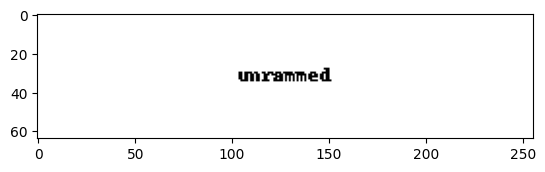

tensor([47, 40, 44, 27, 39, 39, 31, 30,  0,  0,  0,  0,  0,  0,  0,  0,  0])


In [9]:
from matplotlib import pyplot as plt

for images, labels in train_loader:
    plt.imshow(images[1].squeeze(), cmap='gray')
    plt.show()
    print(labels[1])
    break

### Trainer and Evaluator

In [10]:
def train_loop(model, optimizer, dataloader, device):
    model.train()
    total_loss = 0
    loop = tqdm(dataloader, total=len(dataloader))
    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs, loss = model(images, labels)
        # print(loss)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())
    return total_loss/len(dataloader)

def eval_loop(model, optimiser, dataloader, device):
    model.eval()
    total_loss = 0
    preds = []
    loop = tqdm(dataloader, total=len(dataloader))
    with torch.no_grad():
      for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)
        outputs, loss = model(images, labels)
        total_loss += loss
        preds.append(outputs)
        loop.set_postfix(loss=loss.item())
    return preds, total_loss/len(dataloader)

### Decoder

In [11]:
def decoder(preds, label_encoder):
    preds = preds.permute(1, 0, 2)
    preds = torch.softmax(preds, dim=2)
    preds = torch.argmax(preds, dim=2)
    preds = preds.detach().cpu().numpy()

    pred_words = []
    for pred in preds:
        if (pred == 0).any():
            pred = pred[:np.argmax(pred == 0)]
        pred_str = label_encoder.inverse_transform(pred-1)
        pred_words.append(pred_str)
    return pred_words
    

### Model

In [12]:
import torch.nn.functional as F

class CNNRNNModel(nn.Module):
    def __init__(self, num_classes, in_channels, dropout):
        super(CNNRNNModel, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2)
        )
        self.rnn = nn.LSTM(64, 32, 2, batch_first=True, bidirectional=True, dropout=dropout)
        self.output = nn.Linear(64, num_classes)

        self.fc = nn.Linear(1024, 64)
        self.do = nn.Dropout(dropout)

    def forward(self, x, labels=None):
        features = self.cnn(x)
        b, c, h, w = features.size()
        features = features.permute(0, 3, 1, 2).view(b, w, -1)

        fcn_out = self.fc(features)
        fcn_out = self.do(fcn_out)

        rnn_out, _ = self.rnn(fcn_out)

        output = self.output(rnn_out).permute(1, 0, 2)

        if (labels is not None):
          out_log = F.log_softmax(output, dim=2)
          input_lengths = torch.full(size=(b,), fill_value=output.size(0), dtype=torch.long)
          target_lengths = torch.full(size=(b,), fill_value=labels.size(1), dtype=torch.long)
          loss = nn.CTCLoss(blank=0)(out_log, labels, input_lengths, target_lengths)
          # print(type(output))
          return output, loss
        else:
          return output, None

model = CNNRNNModel(52, in_channels=1, dropout=0.2)
model = model.to('cpu')

In [13]:
torch.cuda.empty_cache()

def evaluate_metric(preds, targets, encoder):
    correct_chars = 0
    total_chars = 0

    preds_decoded = torch.argmax(preds, dim=2) 

    for pred, target in zip(preds_decoded, targets):
        pred_str = encoder.inverse_transform(pred)
        target_str = encoder.inverse_transform(target)

        for p, t in zip(pred_str, target_str):
            if p == t:
                correct_chars += 1
            total_chars += 1

    return correct_chars / total_chars

In [14]:
optimizer = optim.Adam(model.parameters(), lr=3e-4)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=5, verbose=True)

for epochs in range(10):
    train_loss = train_loop(model, optimizer, train_loader, 'cpu')
    preds, test_loss = eval_loop(model, optimizer, test_loader, 'cpu')
    print(f"Epoch: {epochs} - Train loss: {train_loss}, Val_loss: {test_loss}")
    # for i in range(5):
    #     print(evaluate_metric(preds[i], test_gt[i], encoder))

  0%|          | 0/250 [00:00<?, ?it/s]C:\Users\Admin\AppData\Local\Temp\ipykernel_6736\867717337.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = [torch.tensor(label) for label in labels]
100%|██████████| 63/63 [00:22<00:00,  2.79it/s, loss=3.38]


Epoch: 0 - Train loss: 4.804193627357483, Val_loss: 3.027109146118164


100%|██████████| 63/63 [00:12<00:00,  4.90it/s, loss=1.77]


Epoch: 1 - Train loss: 1.746430400133133, Val_loss: 1.5545705556869507


100%|██████████| 63/63 [00:11<00:00,  5.50it/s, loss=1.77]


Epoch: 2 - Train loss: 1.6121973214149474, Val_loss: 1.5547677278518677


100%|██████████| 63/63 [00:10<00:00,  5.89it/s, loss=1.77]


Epoch: 3 - Train loss: 1.6051521275043488, Val_loss: 1.5547298192977905


100%|██████████| 63/63 [00:10<00:00,  5.84it/s, loss=1.77]


Epoch: 4 - Train loss: 1.5917370755672455, Val_loss: 1.55474853515625


100%|██████████| 63/63 [00:10<00:00,  5.84it/s, loss=1.77]


Epoch: 5 - Train loss: 1.5932969262599945, Val_loss: 1.5548661947250366


100%|██████████| 63/63 [00:10<00:00,  6.26it/s, loss=1.77]


Epoch: 6 - Train loss: 1.6139304370880128, Val_loss: 1.5548958778381348


100%|██████████| 63/63 [00:10<00:00,  6.25it/s, loss=1.77]


Epoch: 7 - Train loss: 1.5970918126106262, Val_loss: 1.5546289682388306


100%|██████████| 63/63 [00:20<00:00,  3.10it/s, loss=1.77]


Epoch: 8 - Train loss: 1.609384905576706, Val_loss: 1.554884672164917


100%|██████████| 63/63 [00:20<00:00,  3.11it/s, loss=1.77]

Epoch: 9 - Train loss: 1.6198647019863128, Val_loss: 1.5549041032791138
